# **News: Gemini (Google)**

Website: https://deepmind.google/technologies/gemini/

Blogpost: https://blog.google/technology/ai/google-gemini-ai

Mutlimodality video: https://twitter.com/GoogleDeepMind/status/1732461149554094259

Paper: https://paperswithcode.com/paper/gemini-a-family-of-highly-capable-multimodal

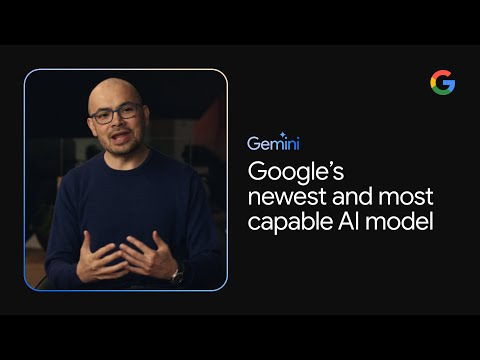

In [46]:
from IPython.display import YouTubeVideo
YouTubeVideo('jV1vkHv4zq8')

# **Keras 3.0**

Most important features:
- multi-backend (Tensorflow, JAX, Pytorch)
- Keras Ops module
- optimized & redesigned
- KerasCV & KerasNLP packages

## **Instalation**

From command line:
```bash
pip3 install keras --upgrade
```

For Anaconda environment:
```bash
conda activate Yourenvironment
conda install pytorch
pip3 install keras --upgrade
```
   
When making a new env:
```bash
conda create -n Keras3 python=3.11 pytorch #(or tensorflow or jax)
conda activate Keras3
pip3 install keras --upgrade
```

For Conda installation, GPU support should set-up automatially. If you encounter issues, checkout the current requirements at https://github.com/keras-team/keras/tree/master.

## **Import & select backend**

From Python script or notebook:
```python
import os
os.environ["KERAS_BACKEND"] = "jax"
```

From command line:
```bash
export KERAS_BACKEND="jax"
```

Permanently:

edit file `keras.json` (usually it's located in `.keras` hidden folder in your home directory)
```json
{
    ...
    "backend": "jax",
    ...
}
```

In [1]:
import matplotlib.pyplot as plt

import os
os.environ["KERAS_BACKEND"] = "torch"

from keras import ops
from keras import layers
from keras.models import Model, Sequential
from keras.metrics import CategoricalAccuracy
from keras.utils import plot_model, to_categorical
from keras.optimizers import Adam
from keras.datasets import mnist

/home/plsek/anaconda3/envs/Keras/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Load data**

In [2]:
(X_train, y_train), (X_val, y_val) = mnist.load_data()

# Normalize 
X_train = X_train / 255
X_val = X_val / 255  

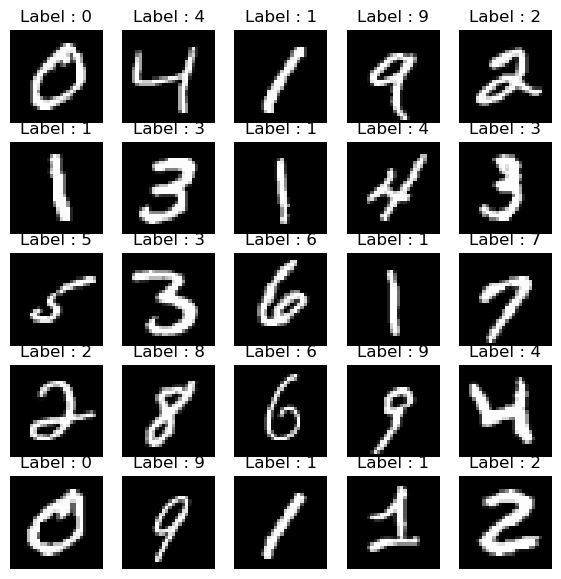

In [3]:
plt.figure(figsize=(7,7))
x = 1
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,x)
        plt.title(f"Label : {y_train[x]}")
        plt.imshow(X_train[x], cmap="gray");
        plt.axis("off")
        x += 1

### **Transform X**

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
# Reshape
X_train = X_train.reshape((*X_train.shape, 1))  
X_val = X_val.reshape((*X_val.shape, 1))

In [6]:
X_train.shape

(60000, 28, 28, 1)

### **Transform Y**

In [7]:
y_train[0]

5

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [9]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [10]:
ops.argmax(y_train[0])

tensor(5, device='cuda:0', dtype=torch.int32)

## **Define network**

In [11]:
def get_model():
    model = Sequential(
        [layers.Input(shape=(28, 28, 1)),
         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
         layers.GlobalAveragePooling2D(),
         layers.Dropout(0.2),
         layers.Dense(10, activation="softmax")]
    )
    
    return model

model = get_model()

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)        │        640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)        │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 64)                │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 10)                │        650 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 38,218 (149.29 KB)

 Trainable params: 38,218 (149.29 KB)

 Non-trainable params: 0 (0.00 B)

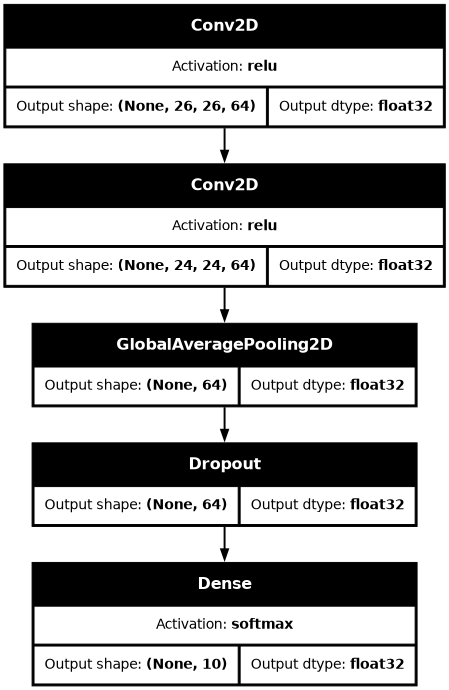

In [13]:
plot_model(
    model,
    dpi=70,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True,
    rankdir="TB"
)

## **Train model**

### **Default `.fit` method**

In [16]:
model = get_model()

model.compile(optimizer=Adam(learning_rate=0.002),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=64, epochs=10)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.2944 - loss: 1.8638 - val_categorical_accuracy: 0.6075 - val_loss: 1.2528
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.5191 - loss: 1.3258 - val_categorical_accuracy: 0.7365 - val_loss: 0.9225
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.6236 - loss: 1.0686 - val_categorical_accuracy: 0.7967 - val_loss: 0.7325
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.7003 - loss: 0.8942 - val_categorical_accuracy: 0.8369 - val_loss: 0.5890
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.7543 - loss: 0.7449 - val_categorical_accuracy: 0.8772 - val_loss: 0.4691
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.7853 - loss: 0.6466 - val_categorical_accuracy: 0.8881 - val_loss: 0.4092
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.8073 - los

In [ ]:
# nvtop
# watch -d -n 1 nvidia-smi

### **Custom fit**

In [17]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### **optimizer \& loss function**

In [18]:
# Load Keras model
model = get_model()

# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Loss function: Crossenstropy
loss_fn = torch.nn.CrossEntropyLoss()

def loss_fn(y_true, y_pred):
    # Clipping - keeps the sum of y_pred at 1
    y_pred = ops.clip(y_pred, 1e-7, 1 - 1e-7)
    
    loss = -(y_true * ops.log(y_pred) + (1 - y_true) * ops.log(1 - y_pred))
    return ops.mean(loss)

#### **1. input array (batchsize $\,\times\,$ image shape)**

In [19]:
batchsize = 16

inputs = torch.tensor(X_train[0:batchsize], device=device)
targets = torch.tensor(y_train[0:batchsize], device=device)

print(inputs.shape, targets.shape)

torch.Size([16, 28, 28, 1]) torch.Size([16, 10])


In [20]:
print(inputs.device, targets.device)

cuda:0 cuda:0


#### **2. forward pass - array of probabilities (batchsize $\,\times\,$ classes)**

In [21]:
probs = model(inputs)

probs.shape

torch.Size([16, 10])

In [22]:
probs[0]

tensor([0.0992, 0.1000, 0.0995, 0.0994, 0.0987, 0.0978, 0.0986, 0.1020, 0.1033,
        0.1013], device='cuda:0', grad_fn=<SelectBackward0>)

In [23]:
probs[0].sum()

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

#### **3. calculate the loss**

In [24]:
loss = loss_fn(probs, targets)

loss

tensor(2.8869, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward1>)

#### **4. backward pass**

In [25]:
model.zero_grad()

loss.backward()

#### **5. optimizer**

In [26]:
optimizer.step()

#### **check if model changed**

In [27]:
probs2 = model(inputs)

loss2 = loss_fn(probs2, targets)

loss2

tensor(2.8672, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward1>)

### **Training loop**

In [29]:
# Load Keras model
model = get_model()

# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Loss function: Crossenstropy
loss_fn = torch.nn.CrossEntropyLoss()


batchsize = 128
epochs = 10
number_of_updates = X_train.shape[0] // batchsize

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    
    for step in range(number_of_updates):
        i0 = step * batchsize
        i1 = (step+1) * batchsize
        
        # Pytorch Tensor + Send to GPU
        inputs = torch.tensor(X_train[i0:i1], device=device)
        targets = torch.tensor(y_train[i0:i1], device=device)
        
        # Forward pass
        probs = model(inputs)
        loss = loss_fn(probs, targets)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Optimizer variable updates
        optimizer.step()

        # Log every 1000 batches.
        if i1 % 1000 == 0:
            print(f"Training loss at step {step:4d} ({(step + 1) * batchsize:5d} images): {loss.cpu().detach().numpy():.4f}")

Epoch: 1
Training loss at step  124 (16000 images): 2.1689
Training loss at step  249 (32000 images): 2.1108
Training loss at step  374 (48000 images): 2.1075
Epoch: 2
Training loss at step  124 (16000 images): 1.9885
Training loss at step  249 (32000 images): 2.0236
Training loss at step  374 (48000 images): 2.0486
Epoch: 3
Training loss at step  124 (16000 images): 1.9419
Training loss at step  249 (32000 images): 1.9888
Training loss at step  374 (48000 images): 2.0377
Epoch: 4
Training loss at step  124 (16000 images): 1.9462
Training loss at step  249 (32000 images): 1.9874
Training loss at step  374 (48000 images): 2.0266
Epoch: 5
Training loss at step  124 (16000 images): 1.8903
Training loss at step  249 (32000 images): 1.8808
Training loss at step  374 (48000 images): 1.9382
Epoch: 6
Training loss at step  124 (16000 images): 1.8794
Training loss at step  249 (32000 images): 1.8710
Training loss at step  374 (48000 images): 1.9365
Epoch: 7
Training loss at step  124 (16000 ima

### **Measure accuracy**

In [30]:
# Load Keras model
model = get_model()

# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loss function: Crossenstropy
loss_fn = torch.nn.CrossEntropyLoss()

# Metrcis: Categorical Accuracy
train_acc_metric = CategoricalAccuracy()
val_acc_metric = CategoricalAccuracy()


batchsize = 128
epochs = 10
number_of_updates = X_train.shape[0] // batchsize

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    
    for step in range(number_of_updates):
        i0 = step * batchsize
        i1 = (step+1) * batchsize
        
        # Pytorch Tensor + Send to GPU
        inputs = torch.tensor(X_train[i0:i1], device=device)
        targets = torch.tensor(y_train[i0:i1], device=device)
        
        # Forward pass
        probs = model(inputs)
        loss = loss_fn(probs, targets)

        # Update metrics
        train_acc_metric.update_state(targets, probs)
        
        # Backward pass
        model.zero_grad()
        loss.backward()

        # Optimizer variable updates
        optimizer.step()

        # Log every 100 batches.
        if i1 % 1000 == 0:
            print(f"Training loss at step {step:4d} ({(step + 1) * batchsize:5d} images): {loss.cpu().detach().numpy():.4f}")
            
    train_acc = train_acc_metric.result()
    print(f"Training acc: {float(train_acc):.4f}")
    
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_state()

    # Calculate 
    val_probs = model(X_val, training=False)
    # Update val metrics
    val_acc_metric.update_state(y_val, val_probs)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_state()
    print(f"Validation acc: {float(val_acc):.4f}\n")

Epoch: 1
Training loss at step  124 (16000 images): 2.1779
Training loss at step  249 (32000 images): 2.1758
Training loss at step  374 (48000 images): 2.1446
Training acc: 0.2772
Validation acc: 0.3671

Epoch: 2
Training loss at step  124 (16000 images): 2.0975
Training loss at step  249 (32000 images): 2.1109
Training loss at step  374 (48000 images): 2.1037
Training acc: 0.3921
Validation acc: 0.4269

Epoch: 3
Training loss at step  124 (16000 images): 2.0333
Training loss at step  249 (32000 images): 2.0628
Training loss at step  374 (48000 images): 2.0716
Training acc: 0.4453
Validation acc: 0.4609

Epoch: 4
Training loss at step  124 (16000 images): 1.9982
Training loss at step  249 (32000 images): 2.0301
Training loss at step  374 (48000 images): 2.0466
Training acc: 0.4820
Validation acc: 0.4682

Epoch: 5
Training loss at step  124 (16000 images): 1.9801
Training loss at step  249 (32000 images): 1.9899
Training loss at step  374 (48000 images): 2.0176
Training acc: 0.5117
Vali

### **Adding a scheduler**

In [ ]:
# Load Keras model
model = get_model()

# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Loss function: Crossenstropy
loss_fn = torch.nn.CrossEntropyLoss()

# Metrcis: Categorical Accuracy
train_acc_metric = CategoricalAccuracy()
val_acc_metric = CategoricalAccuracy()


batchsize = 128
epochs = 10
number_of_updates = X_train.shape[0] // batchsize

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    
    for step in range(number_of_updates):
        i0 = step * batchsize
        i1 = (step+1) * batchsize
        
        # Pytorch Tensor + Send to GPU
        inputs = torch.tensor(X_train[i0:i1], device=device)
        targets = torch.tensor(y_train[i0:i1], device=device)
        
        # Forward pass
        probs = model(inputs)
        loss = loss_fn(probs, targets)

        # Update metrics
        train_acc_metric.update_state(targets, probs)
        
        # Backward pass
        model.zero_grad()
        loss.backward()

        # Optimizer variable updates
        optimizer.step()

        # Log every 100 batches.
        if i1 % 1000 == 0:
            print(f"Training loss at step {step:4d} ({(step + 1) * batchsize:5d} images): {loss.cpu().detach().numpy():.4f}")
            
    if epoch % 2 == 0:
        scheduler.step()
            
    train_acc = train_acc_metric.result()
    print(f"Training acc: {float(train_acc):.4f}")
    
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_state()

    # Calculate 
    val_probs = model(X_val, training=False)
    # Update val metrics
    val_acc_metric.update_state(y_val, val_probs)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_state()
    print(f"Validation acc: {float(val_acc):.4f}\n")

## **Keras: available models**

https://keras.io/api/applications/

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

from keras.ops import expand_dims
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

/home/plsek/anaconda3/envs/Keras/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Predicted: [('n02105412', 'kelpie', 0.9636395), ('n02106550', 'Rottweiler', 0.0074546495), ('n02108000', 'EntleBucher', 0.0070129866)]


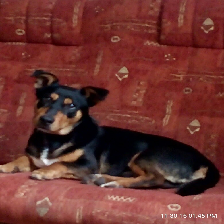

In [2]:
img_path = 'dog.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted: [('n01882714', 'koala', 0.32067764), ('n02481823', 'chimpanzee', 0.28381625), ('n02483708', 'siamang', 0.04188003)]


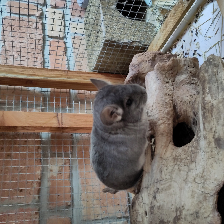

In [3]:
img_path = 'chinchilla.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

img

## **Other platforms with pre-trained models**

- [HuggingFace](https://huggingface.co/models)
    - hub: [OpenAI](https://huggingface.co/openai), [Llama](https://huggingface.co/meta-llama), [StabilityAI](https://huggingface.co/stabilityai/stable-diffusion-2), [CADET](https://huggingface.co/Plsek/CADET-v1)
    - transformers, diffusers, [agents](https://huggingface.co/docs/transformers/transformers_agents)
- [LangChain](https://python.langchain.com/docs/get_started/quickstart) - custom chatbot

100%|██████████| 50/50 [00:05<00:00,  8.85it/s]


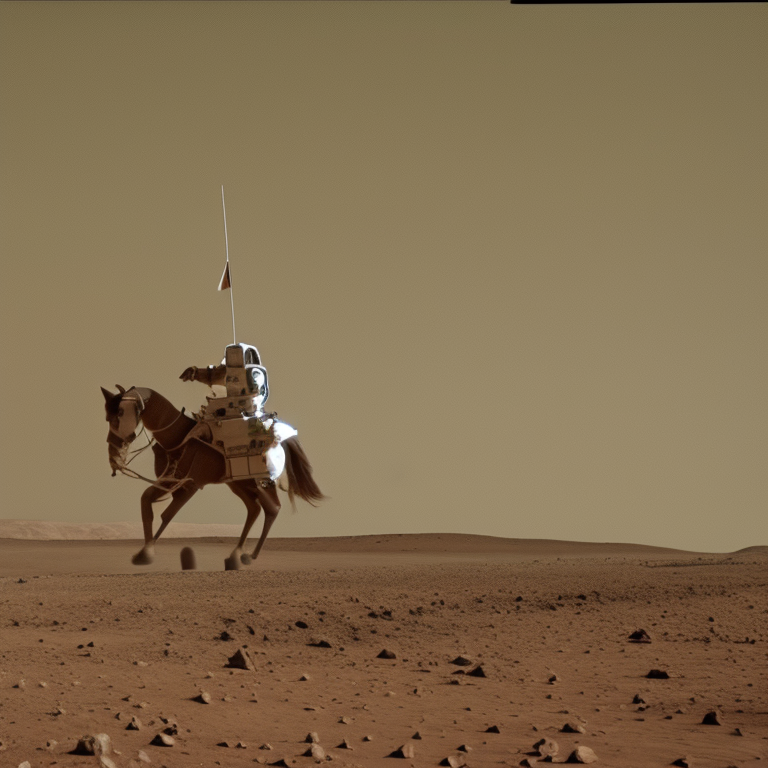

In [5]:
import torch
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler

model_id = "stabilityai/stable-diffusion-2"

# Use the Euler scheduler here instead
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]
    
image.save("astronaut_rides_horse.png")
image

## **Final projects**

Datasets:
- [AstroNN](https://astronn.readthedocs.io/en/stable/galaxy10.html)
- [AstroML](https://www.astroml.org/user_guide/datasets.html)
- [Kaggle](https://www.kaggle.com/)
- [HuggingFace](https://huggingface.co/datasets)

Or build you own dataset:
- filter & preprocess data: 
    - light curves ([OGLE](https://ogledb.astrouw.edu.pl/~ogle/OCVS/))
    - X-ray data ([Chandra](https://cxcfps.cfa.harvard.edu/cda/footprint/cdaview.html))
    - GAIA data ([Astroquery](https://www.cosmos.esa.int/web/gaia-users/archive/programmatic-access))
    - VLBI images ([astrogeo](http://astrogeo.org/vlbi_images/)) 
    - SwiftXRT data ([Swift database](https://www.swift.ac.uk/user_objects/))
- simulate data: 
    - gamma-ray bursts ([cosmogrb](https://github.com/grburgess/cosmogrb))
    - X-ray spectrum ([Sherpa](https://cxc.cfa.harvard.edu/sherpa/threads/fake_pha/))
    - X-ray image ([pyxsim](https://hea-www.cfa.harvard.edu/~jzuhone/pyxsim/cookbook/Thermal_Emission.html))